## Cell 1: Import libraries

Imports packages for data loading, preprocessing, model training, evaluation, and hyperparameter tuning.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

## Cell 2: Load post-arrival dataset

Loads the CSV file and prints the column names so you can confirm the schema.

In [2]:
FILE_NAME = "POST-ARRIVAL_STUDENT_MENTAL_HEALTH_SURVEY_EXTENDED.csv"
df = pd.read_csv(FILE_NAME)

print("Shape:", df.shape)
display(df.head())

print("\nColumns:")
for c in df.columns:
    print(repr(c))

Shape: (148, 31)


,Timestamp,1. Age Group,2. Gender,3.Academic Level,4. Country you are currently studying in.,5. How often do you feel overwhelmed by your responsibilities abroad?,6.How often do you feel nervous or on edge since arriving abroad?,7. How difficult is it for you to relax after your daily activities while living abroad?,8. How often do you feel low energy or lack motivation due to stress?,9. How often do you struggle with concentration because of mental pressure?,...,21. How stressed are you about managing living expenses abroad?,22. Do financial difficulties affect your emotional well-being?,23. How anxious are you about long-term visa or immigration matters?,24. How confident are you in finding stable work or financial support abroad?,25. Do you feel emotionally supported by your family while living abroad?,26. How often do you feel homesick?,27. How comfortable are you sharing emotional struggles with family or friends?,28. Do you get sufficient sleep (7–8 hours)?,29. How often do you engage in physical activity or exercise?,"30. Do you practice relaxation activities (prayer, meditation, breathing exercises)?"
0,2025/12/08 11:15:55 PM GMT+6,22-26,Male,Masters,USA,2.0,4.0,Yes,4.0,4.0,...,4.0,Yes,5.0,2.0,Yes,2.0,4.0,No,1.0,No
1,2025/12/15 10:01:13 PM GMT+6,18-22,Male,Masters,Australia,1.0,2.0,1,1.0,2.0,...,3.0,Yes,2.0,4.0,Yes,4.0,4.0,No,4.0,Yes
2,2025/12/15 10:03:03 PM GMT+6,26-30,Female,Masters,usa,4.0,4.0,3,4.0,4.0,...,4.0,Yes,4.0,2.0,No,4.0,4.0,No,4.0,No
3,2025/12/15 10:06:44 PM GMT+6,26-30,Female,Masters,Australia,4.0,4.0,4,3.0,4.0,...,4.0,Yes,4.0,3.0,Yes,4.0,4.0,No,4.0,Yes
4,2025/12/15 10:06:50 PM GMT+6,18-22,Male,Masters,Sweeden,2.0,2.0,2,2.0,4.0,...,3.0,Yes,3.0,4.0,Yes,3.0,4.0,Yes,4.0,Yes



Columns:
'Timestamp'
'  1. Age Group  '
'  2. Gender  '
'3.Academic Level  '
'  4. Country you are currently studying in.  '
'  5. How often do you feel overwhelmed by your responsibilities abroad?  '
'6.How often do you feel nervous or on edge since arriving abroad?  '
'  7.  How difficult is it for you to relax after your daily activities while living abroad? '
'  8. How often do you feel low energy or lack motivation due to stress?   '
' 9. How often do you struggle with concentration because of mental pressure?  '
'10. How confident are you in handling emotional ups and downs abroad?  '
' 11. How difficult was cultural adjustment after arriving?  '
' 12. How often do you feel socially isolated or lonely abroad?  '
'  13. How confident are you in communicating with people in your new country?  '
' 14. Do you feel accepted by classmates, peers, or community members?  '
' 15. How concerned are you about finding and maintaining friendships abroad?  '
'16. How stressful is the academic

## Cell 3: Select target-question columns (following LR.ipynb selection)

Selects the same question-number set used in your friend's LR notebook (Q5, Q6, Q8, Q9, Q11, Q12, Q14, Q20, Q22, Q24, Q30). If Q24 does not exist but a sleep question exists (often Q28), it will be used instead.

In [3]:
# Question numbers used to create the target (from friend's LR notebook)
desired_qnums = ['5.', '6.', '8.', '9.', '11.', '12.', '14.', '20.', '22.', '24.', '30.']

# Helper: find columns that start with a given question number
def cols_starting_with(qnum: str):
    return [c for c in df.columns if isinstance(c, str) and c.strip().startswith(qnum)]

target_cols = []
for q in desired_qnums:
    target_cols.extend(cols_starting_with(q))

# Special fallback: if Q24 not found, try to find a sleep question (often Q28)
if not cols_starting_with("24."):
    sleep_candidates = [c for c in df.columns if isinstance(c, str) and ("sleep" in c.lower())]
    # Prefer a sleep candidate that starts with 28. if present
    sleep_28 = [c for c in sleep_candidates if c.strip().startswith("28.")]
    if sleep_28:
        target_cols.extend(sleep_28)
    elif sleep_candidates:
        target_cols.extend(sleep_candidates[:1])

# Remove duplicates while preserving order
seen=set()
target_cols = [c for c in target_cols if not (c in seen or seen.add(c))]

print("Detected target columns:")
for c in target_cols:
    print("-", c)
print("Total detected:", len(target_cols))

Detected target columns:
-   5. How often do you feel overwhelmed by your responsibilities abroad?  
- 6.How often do you feel nervous or on edge since arriving abroad?  
-   8. How often do you feel low energy or lack motivation due to stress?   
-  9. How often do you struggle with concentration because of mental pressure?  
-  11. How difficult was cultural adjustment after arriving?  
-  12. How often do you feel socially isolated or lonely abroad?  
-  14. Do you feel accepted by classmates, peers, or community members?  
-   20. How confident are you in adapting to academic standards abroad?  
-   22. Do financial difficulties affect your emotional well-being?  
- 24. How confident are you in finding stable work or financial support abroad?  
-   30. Do you practice relaxation activities (prayer, meditation, breathing exercises)?  
Total detected: 11


## Cell 4: Clean target columns (numeric + Yes/No mapping)

Converts mixed answers (numeric strings, Yes/No) into numeric form and fills missing values.

In [4]:
def to_numeric_mixed(series: pd.Series) -> pd.Series:
    if series.dtype == "object":
        s = series.astype(str).str.strip().str.lower()
        s = s.replace({
            "yes": "1", "no": "0",
            "y": "1", "n": "0",
            "true": "1", "false": "0",
        })
        return pd.to_numeric(s, errors="coerce")
    return pd.to_numeric(series, errors="coerce")

for col in target_cols:
    df[col] = to_numeric_mixed(df[col])

# Fill NaNs column-wise
for col in target_cols:
    if df[col].isna().all():
        # fallback to 0 if totally NaN
        df[col] = df[col].fillna(0)
    else:
        df[col] = df[col].fillna(df[col].median())

df[target_cols].head()

,5. How often do you feel overwhelmed by your responsibilities abroad?,6.How often do you feel nervous or on edge since arriving abroad?,8. How often do you feel low energy or lack motivation due to stress?,9. How often do you struggle with concentration because of mental pressure?,11. How difficult was cultural adjustment after arriving?,12. How often do you feel socially isolated or lonely abroad?,"14. Do you feel accepted by classmates, peers, or community members?",20. How confident are you in adapting to academic standards abroad?,22. Do financial difficulties affect your emotional well-being?,24. How confident are you in finding stable work or financial support abroad?,"30. Do you practice relaxation activities (prayer, meditation, breathing exercises)?"
0,2.0,4.0,4.0,4.0,4.0,5.0,1.0,2.0,1.0,2.0,0.0
1,1.0,2.0,1.0,2.0,1.0,1.0,1.0,5.0,1.0,4.0,1.0
2,4.0,4.0,4.0,4.0,5.0,4.0,0.0,4.0,1.0,2.0,0.0
3,4.0,4.0,3.0,4.0,1.0,2.0,0.0,4.0,1.0,3.0,1.0
4,2.0,2.0,2.0,4.0,4.0,2.0,1.0,4.0,1.0,4.0,1.0


## Cell 5: Create continuous distress score

Averages the selected target columns to compute a continuous score (higher = worse distress).

In [5]:
df["Distress_Score"] = df[target_cols].mean(axis=1)
display(df["Distress_Score"].describe())

count    148.000000
mean       2.461916
std        0.363561
min        1.727273
25%        2.363636
50%        2.454545
75%        2.727273
max        3.090909
Name: Distress_Score, dtype: float64

## Cell 6: Convert distress score into categorical target

Creates a 4-class label: No/Minimal, Mild, Moderate, Severe.

In [6]:
def distress_level(score: float) -> str:
    if score <= 2.0:
        return "No/Minimal"
    elif score <= 3.0:
        return "Mild"
    elif score <= 4.0:
        return "Moderate"
    else:
        return "Severe"

df["Distress_Level"] = df["Distress_Score"].apply(distress_level)
print(df["Distress_Level"].value_counts())

Distress_Level
Mild          119
No/Minimal     27
Moderate        2
Name: count, dtype: int64


## Cell 7: Drop leakage columns

Drops the target columns and score column from the feature set to prevent data leakage.

In [7]:
df_model = df.drop(columns=target_cols + ["Distress_Score"])

## Cell 8: Define features (X) and target (y)

Splits predictors from the target label used for classification.

In [8]:
X = df_model.drop(columns=["Distress_Level"])
y = df_model["Distress_Level"]

print("X shape:", X.shape)
print("y distribution:")
print(y.value_counts())

X shape: (148, 20)
y distribution:
Distress_Level
Mild          119
No/Minimal     27
Moderate        2
Name: count, dtype: int64


## Cell 9: Identify numeric and categorical columns

Separates numeric and categorical columns for preprocessing.

In [9]:
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

print("Categorical cols:", list(categorical_cols))
print("Numeric cols:", list(numeric_cols))

Categorical cols: ['Timestamp', '  1. Age Group  ', '  2. Gender  ', '3.Academic Level  ', '  4. Country you are currently studying in.  ', '  7.  How difficult is it for you to relax after your daily activities while living abroad? ', '  17. Do you feel pressure to achieve high academic results?  ', '  19. How often do you feel stressed before exams or deadlines?   ', '  25. Do you feel emotionally supported by your family while living abroad?  ', '  28. Do you get sufficient sleep (7–8 hours)?  ']
Numeric cols: ['10. How confident are you in handling emotional ups and downs abroad?  ', '  13. How confident are you in communicating with people in your new country?  ', ' 15. How concerned are you about finding and maintaining friendships abroad?  ', '16. How stressful is the academic workload in your institution?  ', ' 18. How challenging is it to balance academics with part-time work (if applicable)?   ', '  21. How stressed are you about managing living expenses abroad?  ', '  23. Ho

## Cell 10: Build preprocessing pipeline

Numeric: median imputation + standard scaling. Categorical: mode imputation + one-hot encoding.

In [10]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

## Cell 11: Train-test split (stratified)

Splits data into train and test sets while maintaining class proportions.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (118, 20) Test: (30, 20)


## Cell 12: LightGBM baseline training

Trains a baseline LightGBM classifier and evaluates performance on the test set.

LGBM Accuracy: 0.9333333333333333
LGBM Weighted F1: 0.9498327759197326
              precision    recall  f1-score   support

        Mild       1.00      0.92      0.96        24
    Moderate       0.00      0.00      0.00         0
  No/Minimal       0.86      1.00      0.92         6

    accuracy                           0.93        30
   macro avg       0.62      0.64      0.63        30
weighted avg       0.97      0.93      0.95        30



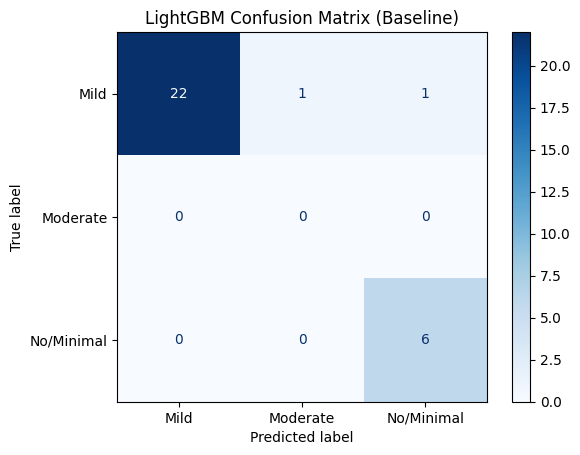

In [12]:
lgbm_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LGBMClassifier(
        n_estimators=600,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42,
        verbose=-1,
        force_row_wise=True
    ))
])

lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)

print("LGBM Accuracy:", accuracy_score(y_test, y_pred))
print("LGBM Weighted F1:", f1_score(y_test, y_pred, average="weighted"))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("LightGBM Confusion Matrix (Baseline)")
plt.show()

## Cell 13: LightGBM hyperparameter tuning

Tunes LightGBM hyperparameters using RandomizedSearchCV and weighted F1 scoring.

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lgbm_param_dist = {
    "classifier__n_estimators": [400, 800, 1200],
    "classifier__learning_rate": [0.01, 0.03, 0.05],
    "classifier__num_leaves": [31, 63, 127],
    "classifier__max_depth": [-1, 5, 10],
    "classifier__min_child_samples": [5, 10, 20],
    "classifier__subsample": [0.7, 0.9, 1.0],
    "classifier__colsample_bytree": [0.7, 0.9, 1.0],
    "classifier__reg_alpha": [0.0, 0.1, 0.5],
    "classifier__reg_lambda": [0.0, 0.5, 1.0]
}

lgbm_search = RandomizedSearchCV(
    lgbm_model,
    lgbm_param_dist,
    n_iter=25,
    scoring="f1_weighted",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

lgbm_search.fit(X_train, y_train)
best_model = lgbm_search.best_estimator_
print("Best LGBM params:", lgbm_search.best_params_)
print("Best CV weighted F1:", lgbm_search.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best LGBM params: {'classifier__subsample': 0.7, 'classifier__reg_lambda': 0.5, 'classifier__reg_alpha': 0.1, 'classifier__num_leaves': 127, 'classifier__n_estimators': 1200, 'classifier__min_child_samples': 20, 'classifier__max_depth': -1, 'classifier__learning_rate': 0.03, 'classifier__colsample_bytree': 1.0}
Best CV weighted F1: 0.9422904390295695


## Cell 14: Evaluate tuned LightGBM

Evaluates the tuned LightGBM model on the test set and displays the confusion matrix.

Tuned LGBM Accuracy: 0.9666666666666667
Tuned LGBM Weighted F1: 0.96759410801964
              precision    recall  f1-score   support

        Mild       1.00      0.96      0.98        24
  No/Minimal       0.86      1.00      0.92         6

    accuracy                           0.97        30
   macro avg       0.93      0.98      0.95        30
weighted avg       0.97      0.97      0.97        30



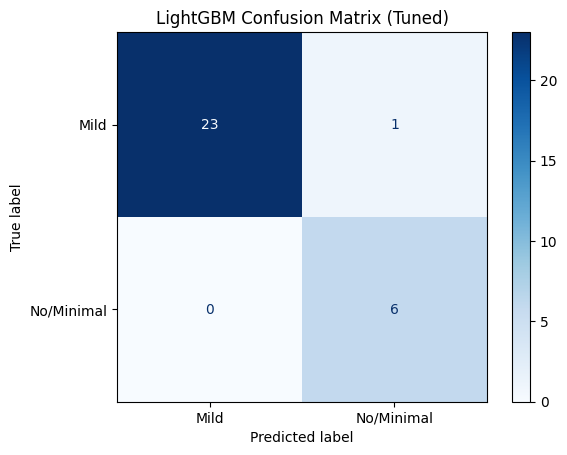

In [14]:
y_pred_tuned = best_model.predict(X_test)

print("Tuned LGBM Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Tuned LGBM Weighted F1:", f1_score(y_test, y_pred_tuned, average="weighted"))
print(classification_report(y_test, y_pred_tuned))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tuned, cmap="Blues")
plt.title("LightGBM Confusion Matrix (Tuned)")
plt.show()

## Cell 15: Save tuned model 

Saves the tuned preprocessing + LightGBM pipeline for later use.

In [15]:
import joblib
joblib.dump(best_model, "post_arrival_lightgbm_tuned.joblib")
print("Saved: post_arrival_lightgbm_tuned.joblib")

Saved: post_arrival_lightgbm_tuned.joblib
